## 강화학습 흐름
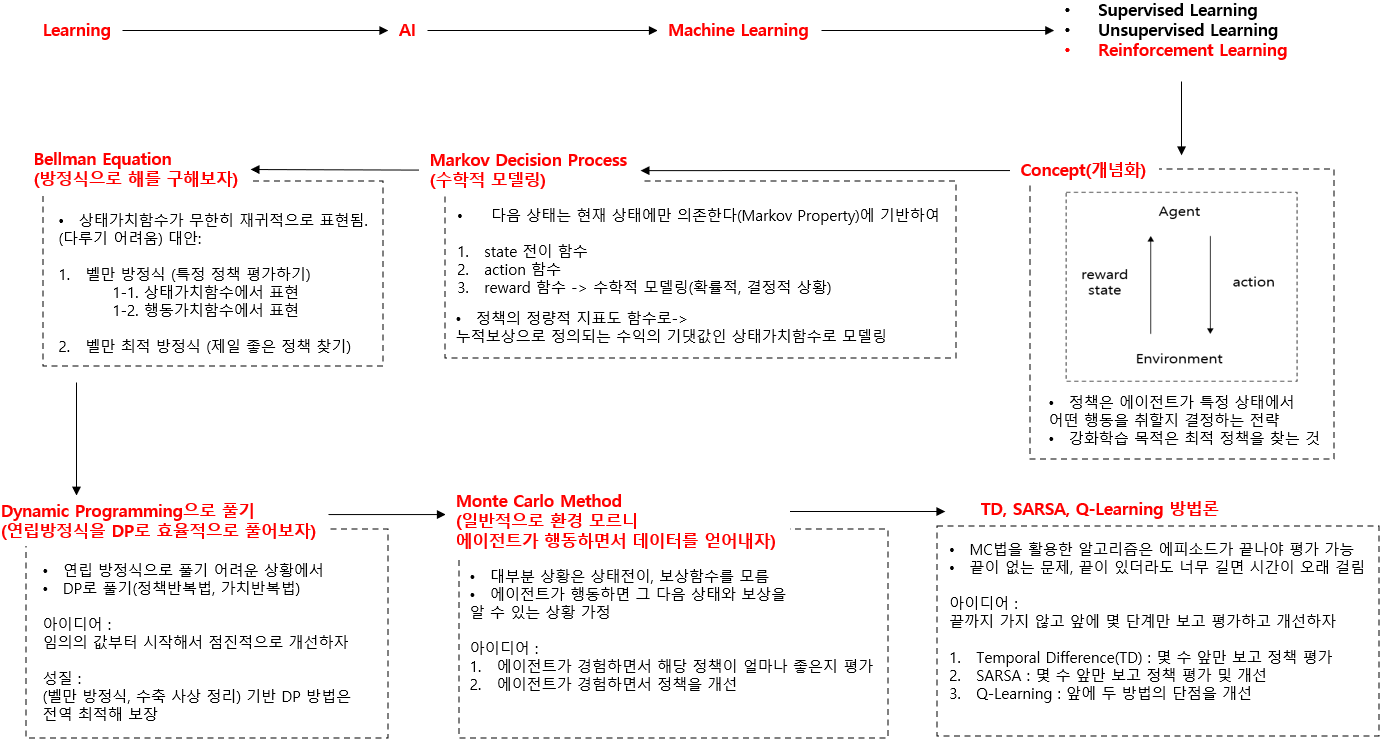
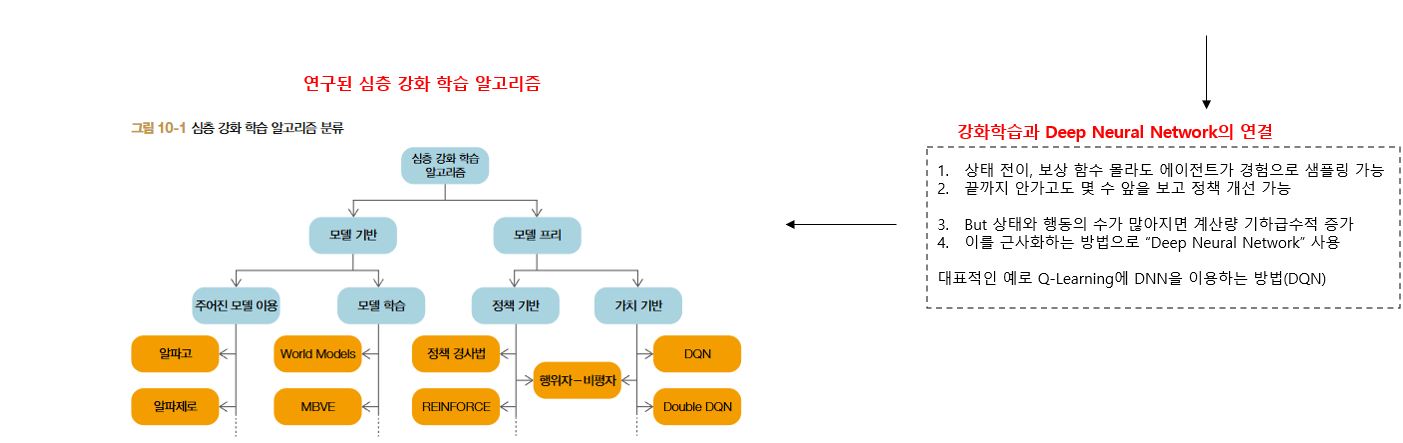

# 
# 
#### 이번 장은
- 많은 경우 환경(상태 전이 확률과 보상 함수)을 모르므로 동적 프로그래밍으로 구현할 수 없음.
- 이러한 경우 에이전트가 실제로 행동하며 얻은 경험을 토대로 학습해야함

#### 몬테카를로법(Monte carlo method) :
- 데이터를 반복적으로 샘플링하여 그 결과를 토대로 추정하는 방법을 일컬음
#### 강화학습에서는
- 몬테카를로법을 통해 경험으로부터 가치 함수를 추정할 수 있음.
- "경험"은 환경과 에이전트가 실제로 상호작용하여 얻은 데이터를 의미함.
- 경험 -> 가치 함수 추정 -> 최적 정책 찾기

# 
### 5.1 몬테카를로법 기초
1. 확률분포를 아는 경우와
2. 모르는 경우 하지만 샘플링을 할 수 있는 경우에 대해 다뤄본다.

# 
#### 5.1.1 예시 : 주사위 눈의 합
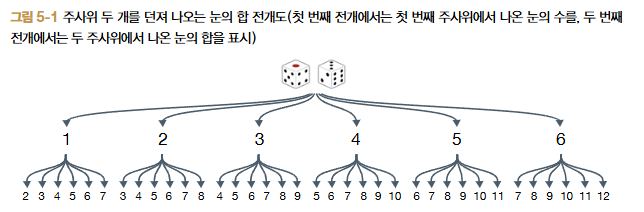
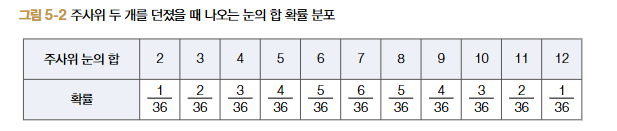

두 주사위의 합에 대한 확률분포를 알고있는 경우 기댓값은 다음과 같음

In [1]:
ps = {2: 1/36, 3: 2/36, 4: 3/36, 5: 4/36, 6: 5/36, 7: 6/36,
      8: 5/36, 9: 4/36, 10: 3/36, 11: 2/36, 12: 1/36}

V = 0
for x, p in ps.items():
    V += x*p
print(V) # [출력 결과] 6.999999999999999 부동 소수점 계산 오류

6.999999999999999


# 
#### 5.1.2 분포 모델과 샘플 모델
1. 확률분포로 표현된 모델 : 분포 모델
2. 표본을 추출할 수 있는 모델 : 샘플 모델
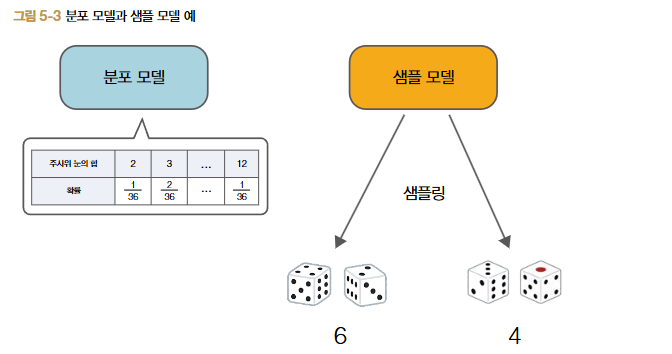

In [2]:
import numpy as np

def sample(dices=2):
    x = 0
    for _ in range(dices):
        x += np.random.choice([1,2,3,4,5,6])
    return x

In [3]:
print(sample())
print(sample())
print(sample())

6
7
7


- 위와 같이 두 주사위 합을 샘플링할 수 있는 모델을 구현하였음.
- 이를 통해 두 주사위 합의 확률분포의 기댓값을 근사화해보자

#### 5.1.3. 몬테카를로법 구현

In [4]:
trial = 1000

samples = []
for _ in range(trial) : 
    s = sample()
    samples.append(s)

V = sum(samples) / len(samples)
print(V)

7.049


- 몬테카를로법은 샘플 수를 늘릴수록 신뢰도가 높아짐.
- 샘플 수가 많아지면 기댓값을 추정하는 표본평균의 분산이 작아짐.

이번에는 샘플을 시행을 할때마다 누적해서 구현해보자(효율적인 표본평균 구현 방법 사용)
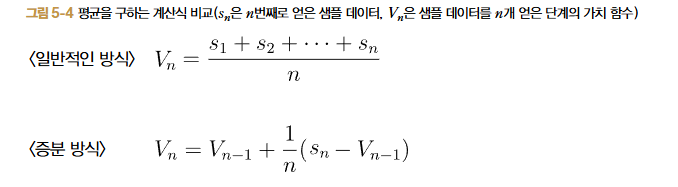

In [5]:
trial = 1000
V, n = 0, 0

for _ in range(trial):
    s = sample()
    n += 1
    V += (s- V) / n
    print(V)

4.0
7.0
6.0
6.75
6.4
6.833333333333334
6.428571428571429
6.625
6.888888888888889
6.7
7.0
6.75
6.769230769230769
6.642857142857142
6.466666666666666
6.249999999999999
6.058823529411764
6.222222222222221
6.31578947368421
6.499999999999999
6.57142857142857
6.499999999999999
6.391304347826086
6.333333333333332
6.439999999999999
6.538461538461537
6.5555555555555545
6.749999999999999
6.793103448275861
6.7333333333333325
6.709677419354838
6.749999999999999
6.757575757575757
6.647058823529411
6.657142857142857
6.722222222222221
6.594594594594594
6.473684210526315
6.435897435897435
6.574999999999999
6.658536585365853
6.666666666666666
6.697674418604651
6.681818181818182
6.711111111111111
6.739130434782608
6.76595744680851
6.708333333333333
6.816326530612245
6.72
6.705882352941177
6.673076923076923
6.716981132075472
6.703703703703704
6.654545454545455
6.6607142857142865
6.631578947368422
6.63793103448276
6.661016949152543
6.633333333333335
6.606557377049182
6.661290322580647
6.61904761904762
6.6

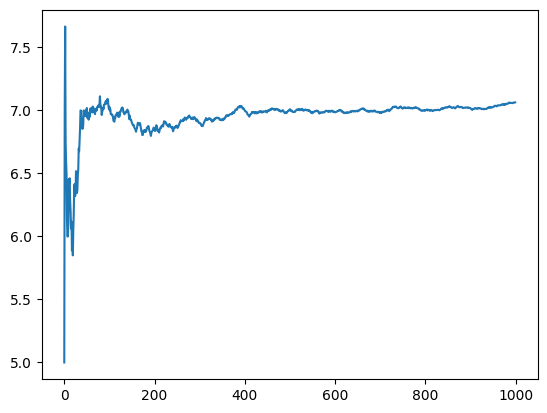

In [6]:
import matplotlib.pyplot as plt
trial = 1000
V, n = 0, 0
V_list = []

for _ in range(trial):
    s = sample()
    n += 1
    V += (s- V) / n
    V_list.append(V)
    
    
plt.plot(np.arange(len(V_list)), V_list)
plt.show()

# 
# 
### 5.2 몬테카를로법으로 정책 평가하기
- 몬테카를로법은 실제로 샘플링을 하고 샘플 데이터로부터 기댓값을 계산함
- 에이전트가 실제로 행동하여 얻은 경험(샘플)으로 가치(기댓값)를 추정할 수 있음
- 이번 절에서는 몬테카를로법으로 정책을 평가하는 것까지만 하고 최적 정책을 찾는 것은 그 후 절에서 들여다볼 것임

# 
#### 5.2.1 가치 함수를 몬테카를로법으로 구하기
가치함수 복습 : 
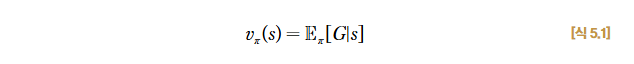
가치함수는 상태 $s$에서 정책 $\pi$ 에 따라 행동했을 때 얻을 수 있는 기대 수익임.

- 이번 문제는 끝이 있는 일회성 과제로 가정

- 이를 몬테카를로법으로 계산해보는 상황은 다음과 같음.   
    1. 에이전트가 어떻게 행동할 것인지에 대한 정책은 알고 있음.
    2. 하지만 다음 상태들과 보상은 경험을 해봐야지만 나올 수 있는 경우임.
    3. 즉 상태 $s$ 에서 에이전트가 행동하여 끝에 도달하면 샘플 1개가 얻어지고 이 얻어진 가치함수값이 $G^{(i)}$ 임.
    
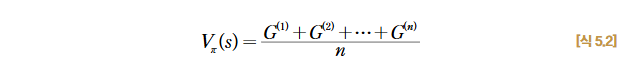
n번에 대한 에피소드에 대해 얻은 것은 위와 같음.

구체적인 예 : 상태 $s$ 에서 시작하여 정책 $\pi$ 에 따라 행동한 결과, 할인율이 1인 경우
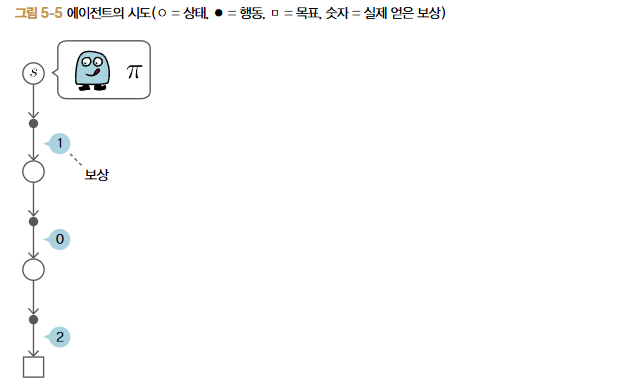
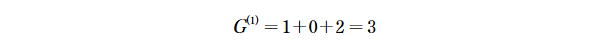
이 시점에서 추정한 가치 함수는 다음과 같음. 샘플 수 1이므로
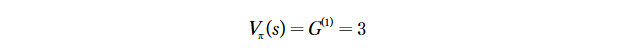

2번째 샘플을 얻은 경우 :
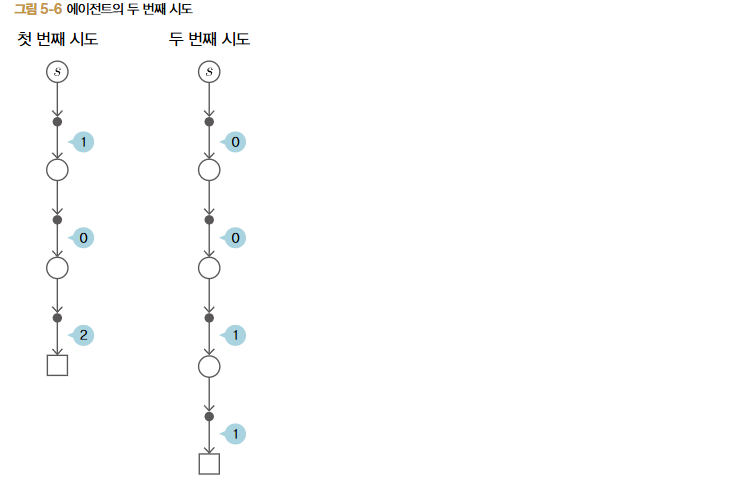
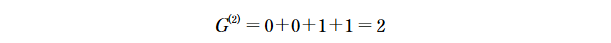
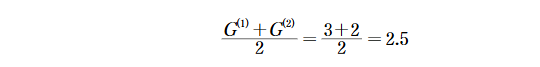
이 시점의 가치 함수 $V_\pi(s)=2.5$ 임. 이를 수없이 많이 시행하면 근사치 정확도가 높아짐.

# 
#### 5.2.2. 모든 상태의 가치 함수 구하기
위에는 $s$ 상태만 구한 것이지만 다른 상태들에 대해서도 모두 수행할 수 있음, A, B, C 상태들이라고 해보면'
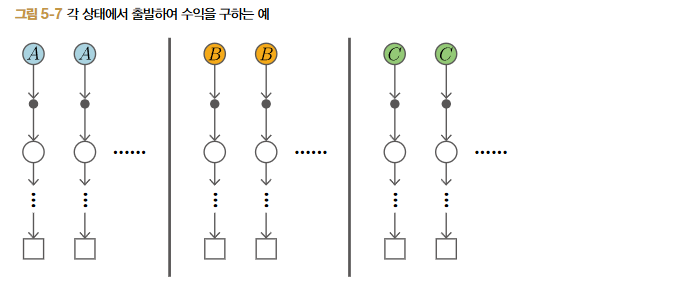

이를 잘 생각해보면 A 상태든 ,다른 상태든 어떤 상태가 다른 상태에 포함되는 관계를 알 수 있음.   
예를 들어 A 상태에서 시작해서 B 그리고 C 상태로 가서 끝났다고 해보자.
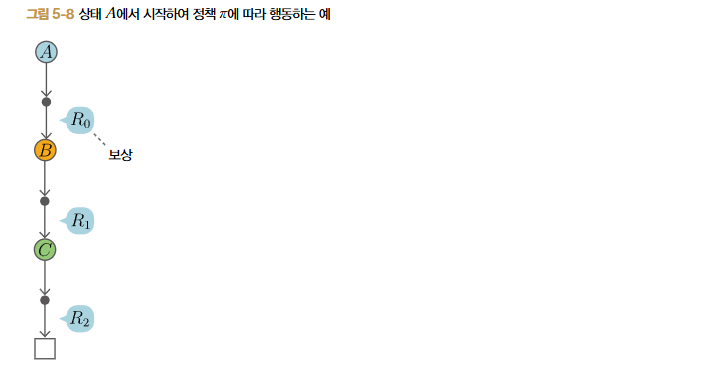
A 상태에서 수익은
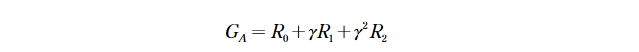

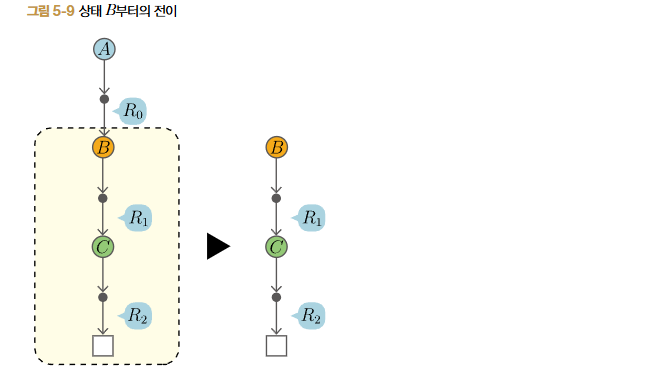
B 상태에서 수익은
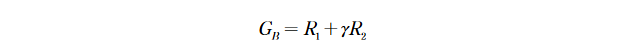
C 상태에서 수익은
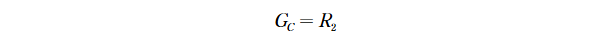
즉 한 번의 에피소드만으로 3가지 상태에 대한 샘플을 얻었다고 할 수 있음

#### 5.2.3 몬테카를로법 계산 효율 구현
- 즉 1회 에피소드에서 A -> B -> C 로 갔다면 1회 샘플이 얻어졌다고 생각할 수 있지만
- C, B, A 상태에서 각 1번씩 3개의 샘플이 얻어졌다고 할 수 있음.
- 그리고 에피소드를 역으로 추적하면 다시 해당 상태들의 수익을 표현함을 유도할 수 있음.
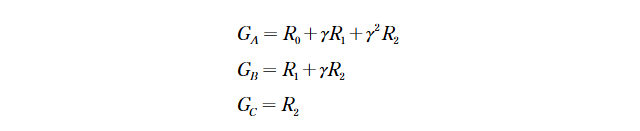

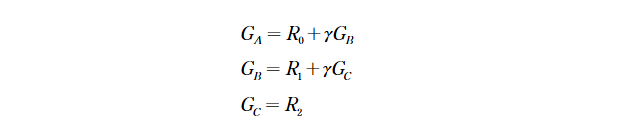
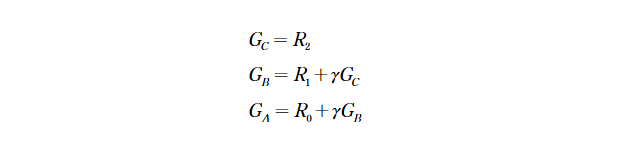

# 
### 5.3 몬테카를로법 구현
- 이번에는 환경 모델(상태 전이 확률과 보상 함수)을 이용하지 않고 정책을 평가함.
- 주의 : 에이전트가 행동하면 다음 상태와 보상은 얻어지는 것임
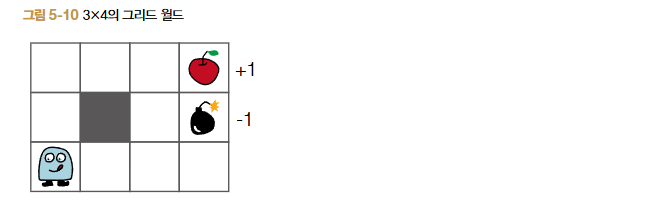

그리드월드 클래스

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 행동 공간(가능한 행동들)
        self.action_meaning = {  # 행동의 의미
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT",
        }

        self.reward_map = np.array(  # 보상 맵(각 좌표의 보상 값)
            [[0, 0, 0, 1.0],
             [0, None, 0, -1.0],
             [0, 0, 0, 0]]
        )
        self.goal_state = (0, 3)    # 목표 상태(좌표)
        self.wall_state = (1, 1)    # 벽 상태(좌표)
        self.start_state = (2, 0)   # 시작 상태(좌표)
        self.agent_state = self.start_state   # 에이전트 초기 상태(좌표)

    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)

    def next_state(self, state, action):
        # 이동 위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        # 이동한 위치가 그리드 월드의 테두리 밖이나 벽인가?
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state

        return next_state  # 다음 상태 반환

    def reward(self, state, action, next_state):
        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)
        
        
class Renderer:
    def __init__(self, reward_map, goal_state, wall_state):
        self.reward_map = reward_map
        self.goal_state = goal_state
        self.wall_state = wall_state
        self.ys = len(self.reward_map)
        self.xs = len(self.reward_map[0])

        self.ax = None
        self.fig = None
        self.first_flg = True

    def set_figure(self, figsize=None):
        fig = plt.figure(figsize=figsize)
        self.ax = fig.add_subplot(111)
        ax = self.ax
        ax.clear()
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_xticks(range(self.xs))
        ax.set_yticks(range(self.ys))
        ax.set_xlim(0, self.xs)
        ax.set_ylim(0, self.ys)
        ax.grid(True)

    def render_v(self, v=None, policy=None, print_value=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax

        if v is not None:
            color_list = ['red', 'white', 'green']
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                'colormap_name', color_list)

            # dict -> ndarray
            v_dict = v
            v = np.zeros(self.reward_map.shape)
            for state, value in v_dict.items():
                v[state] = value

            vmax, vmin = v.max(), v.min()
            vmax = max(vmax, abs(vmin))
            vmin = -1 * vmax
            vmax = 1 if vmax < 1 else vmax
            vmin = -1 if vmin > -1 else vmin

            ax.pcolormesh(np.flipud(v), cmap=cmap, vmin=vmin, vmax=vmax)

        for y in range(ys):
            for x in range(xs):
                state = (y, x)
                r = self.reward_map[y, x]
                if r != 0 and r is not None:
                    txt = 'R ' + str(r)
                    if state == self.goal_state:
                        txt = txt + ' (GOAL)'
                    ax.text(x+.1, ys-y-0.9, txt)

                if (v is not None) and state != self.wall_state:
                    if print_value:
                        offsets = [(0.4, -0.15), (-0.15, -0.3)]
                        key = 0
                        if v.shape[0] > 7: key = 1
                        offset = offsets[key]
                        ax.text(x+offset[0], ys-y+offset[1], "{:12.2f}".format(v[y, x]))

                if policy is not None and state != self.wall_state:
                    actions = policy[state]
                    max_actions = [kv[0] for kv in actions.items() if kv[1] == max(actions.values())]

                    arrows = ["↑", "↓", "←", "→"]
                    offsets = [(0, 0.1), (0, -0.1), (-0.1, 0), (0.1, 0)]
                    for action in max_actions:
                        arrow = arrows[action]
                        offset = offsets[action]
                        if state == self.goal_state:
                            continue
                        ax.text(x+0.45+offset[0], ys-y-0.5+offset[1], arrow)

                if state == self.wall_state:
                    ax.add_patch(plt.Rectangle((x,ys-y-1), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
        plt.show()

    def render_q(self, q, show_greedy_policy=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax
        action_space = [0, 1, 2, 3]

        qmax, qmin = max(q.values()), min(q.values())
        qmax = max(qmax, abs(qmin))
        qmin = -1 * qmax
        qmax = 1 if qmax < 1 else qmax
        qmin = -1 if qmin > -1 else qmin


        color_list = ['red', 'white', 'green']
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'colormap_name', color_list)

        for y in range(ys):
            for x in range(xs):
                for action in action_space:
                    state = (y, x)
                    r = self.reward_map[y, x]
                    if r != 0 and r is not None:
                        txt = 'R ' + str(r)
                        if state == self.goal_state:
                            txt = txt + ' (GOAL)'
                        ax.text(x+.05, ys-y-0.95, txt)

                    if state == self.goal_state:
                        continue

                    tx, ty = x, ys-y-1

                    action_map = {
                        0: ((0.5+tx, 0.5+ty), (tx+1, ty+1), (tx, ty+1)),
                        1: ((tx, ty), (tx+1, ty), (tx+0.5, ty+0.5)),
                        2: ((tx, ty), (tx+0.5, ty+0.5), (tx, ty+1)),
                        3: ((0.5+tx, 0.5+ty), (tx+1, ty), (tx+1, ty+1)),
                    }
                    offset_map = {
                        0: (0.1, 0.8),
                        1: (0.1, 0.1),
                        2: (-0.2, 0.4),
                        3: (0.4, 0.4),
                    }
                    if state == self.wall_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
                    elif state in self.goal_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0., 1., 0., 1.)))
                    else:

                        tq = q[(state, action)]
                        color_scale = 0.5 + (tq / qmax) / 2  # normalize: 0.0-1.0

                        poly = plt.Polygon(action_map[action],fc=cmap(color_scale))
                        ax.add_patch(poly)

                        offset= offset_map[action]
                        ax.text(tx+offset[0], ty+offset[1], "{:12.2f}".format(tq))
        plt.show()

        if show_greedy_policy:
            policy = {}
            for y in range(self.ys):
                for x in range(self.xs):
                    state = (y, x)
                    qs = [q[state, action] for action in range(4)]  # action_size
                    max_action = np.argmax(qs)
                    probs = {0:0.0, 1:0.0, 2:0.0, 3:0.0}
                    probs[max_action] = 1
                    policy[state] = probs
            self.render_v(None, policy)

#### 5.3.1 step() 메서드
그리드월드의 step 메서드는 에이전트가 해당 상태에서 행동을 시켜서 다음 상태와 보상을 얻어내는 함수임

In [8]:
env = GridWorld()
action = 0 # 더미 행동 : 위
next_state, reward, done = env.step(action) # 행동 수행

print("next state : ", next_state )
print("reward : ", reward)
print("done : ", done)

next state :  (1, 0)
reward :  0
done :  False


참고로 done은 에피소드를 끝낼 때 사용할 것임.

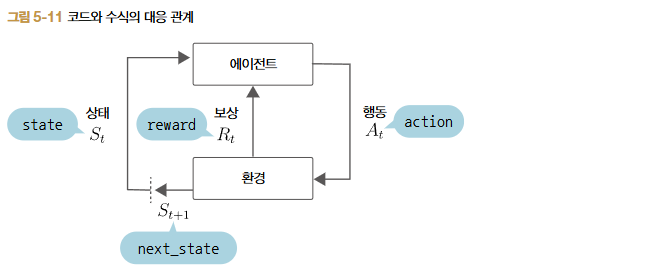

reset 함수는 초기 상태로 변환해줌, 즉 에피소드 출발점임.

In [9]:
env = GridWorld()
state = env.reset()
print(state)

(2, 0)


#### 5.3.2 에이전트 클래스 구현
무작위 정책에 따라 움직이는 에이전트 RandomAgent 클래스 구현

In [10]:
from collections import defaultdict

class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1: 0.25, 2:0.25, 3: 0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.V = defaultdict(lambda : 0)
        self.cnts = defaultdict(lambda : 0)
        self.memeory = []
        
    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action ,reward):
        data = (state, action, reward)
        self.memeory.append(data)
        
    def reset(self):
        self.memeory.clear()
        
    def eval(self):
        G = 0
        for data in reversed(self.memeory):
            state , action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

- get_action : 25% 균등 확률로 행동 정하기
- add : 메모리 추가 (샘플링)
- eval : 거꾸로 가치함수 업데이트

아래와 같이 에이전트는 균등한 확률로 위 아래 왼 오른쪽으로 행동하는 것을 볼 수 있음

In [11]:
agent = RandomAgent()
for i in range(5):
    print(agent.get_action(state))

1
2
0
2
1


# 
#### 5.3.3 몬테카를로법 실행

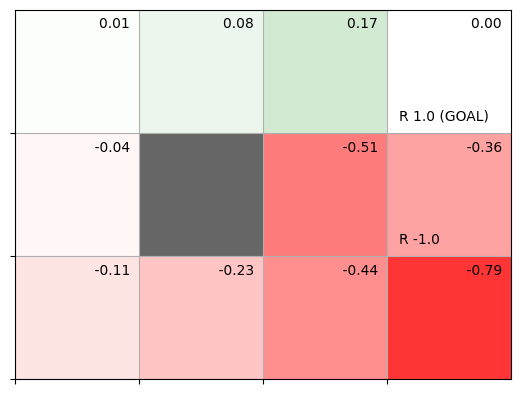

In [12]:
env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()
    
    while True :
        action = agent.get_action(state) # 행동 선택
        next_state, reward, done = env.step(action) # 행동 수행
        
        agent.add(state, action, reward) # 상태 행동 보상 저장
        if done :
            agent.eval() # 몬테카를로법으로 가치 함수 갱신
            break
        
        state = next_state
# 모든 에피소드 종료

env.render_v(agent.V)

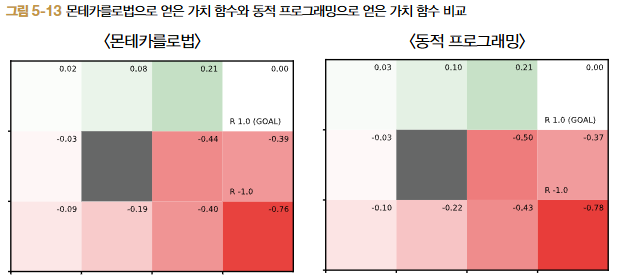

# 
# 
### 5.4 몬테카를로법으로 정책 제어하기
이제 몬테카를로법으로 최적 정책 찾아보기

#### 5.4.1 평가와 개선
4장 동적프로그래밍으로 점진적 개선을 하는 수식은 다음과 같았음
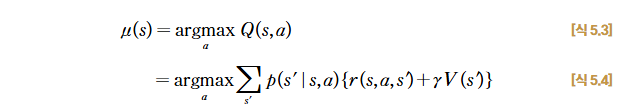

- 일반적으로 환경모델 $p(s'|s,a)$ 와 $r(s,a,s')$ 을 모름.
    1. 식 5.4는 사용할 수 없음
    2. 식 5.3을 이용하는 방법
- Q 함수에 중점을 둚
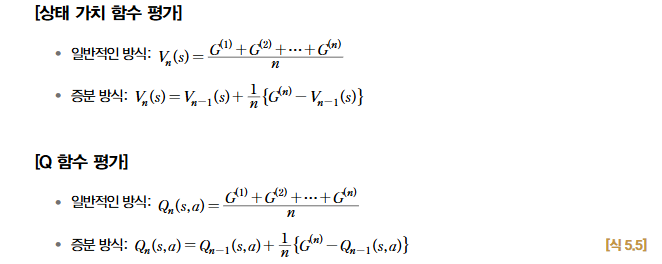

# 
#### 5.4.2 몬테카를로법으로 정책 제어 구현
- 몬테카를로법으로 정책을 제어하는 에이전트 구현 
    1. greedy_probs : 해당 상태에서 에이전트가 확률이 가장 높은 행동을 결정적으로 행동하게 하려는 함수

In [24]:
def greedy_probs(Q, state, action_size =4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    
    base_prob = 1 / action_size
    action_probs = {action : 0.0 for action in range(action_size)}
    
    action_probs[max_action] = 1 # 이 부분 개선
    return action_probs

class McAgent :
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1: 0.25, 2:0.25, 3: 0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.Q = defaultdict(lambda : 0) # self.V = defaultdict  Q로 바뀜
        self.cnts = defaultdict(lambda : 0)
        self.memeory = []
        
    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memeory.append(data)
        
    def reset(self) :
        self.memeory.clear()
        
    def update(self):
        G = 0
        for data in reversed(self.memeory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            print("상태와 액션", key)
            
            self.cnts[key] += 1
            # [식 5.5]에 따라 self.Q 갱신
            print("갱신전 Q ", self.Q)
            self.Q[key] += (G - self.Q[key]) / self.cnts[key] # 이 부분 개선할것임 -> Q 갱신을 고정값 a 방식으로
            
            print("갱신후 Q", self.Q)
            # state 의 정책 탐욕화
            self.pi[state] = greedy_probs(self.Q, state)
            print("탐욕화 후 ", self.pi)

In [30]:
env = GridWorld()
agent = McAgent()

state = env.reset() # 처음 시작 상태로
agent.reset()


action = agent.get_action(state)
print("시작 상태에서 에이전트 액션 : ", action)

next_state, reward, done = env.step(action)
print("액션을 통해 다음 상태로 갔을 때(경험) : ", next_state, reward, done)

agent.add(state, action, reward) # 경험 저장

agent.update() # 에피소드가 끝나지않았지만 확인해보자

시작 상태에서 에이전트 액션 :  3
액션을 통해 다음 상태로 갔을 때(경험) :  (2, 1) 0 False
상태와 액션 ((2, 0), 3)
갱신전 Q  defaultdict(<function McAgent.__init__.<locals>.<lambda> at 0x000001C451CE1090>, {})
갱신후 Q defaultdict(<function McAgent.__init__.<locals>.<lambda> at 0x000001C451CE1090>, {((2, 0), 3): 0.0})
탐욕화 후  defaultdict(<function McAgent.__init__.<locals>.<lambda> at 0x000001C451D863B0>, {(2, 0): {0: 1, 1: 0.0, 2: 0.0, 3: 0.0}})


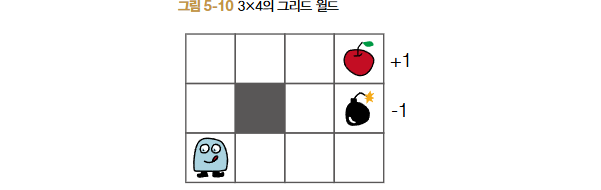

이 상태에서 구현해보기 ( 하지만 반복문이 끝나지 않는 경우가 발생)

defaultdict(<function McAgent.__init__.<locals>.<lambda> at 0x000001E3A01E35B0>, {(2, 0): {0: 0.0, 1: 0.0, 2: 1, 3: 0.0}, (2, 1): {0: 0.0, 1: 0.0, 2: 1, 3: 0.0}, (1, 0): {0: 0.0, 1: 0.0, 2: 0.0, 3: 1}, (0, 0): {0: 0.0, 1: 1, 2: 0.0, 3: 0.0}, (0, 1): {0: 0.0, 1: 0.0, 2: 1, 3: 0.0}, (2, 2): {0: 0.0, 1: 1, 2: 0.0, 3: 0.0}, (1, 2): {0: 0.0, 1: 1, 2: 0.0, 3: 0.0}, (0, 2): {0: 0.0, 1: 0.0, 2: 0.0, 3: 1}, (1, 3): {0: 1, 1: 0.0, 2: 0.0, 3: 0.0}, (2, 3): {0: 0.0, 1: 1, 2: 0.0, 3: 0.0}})


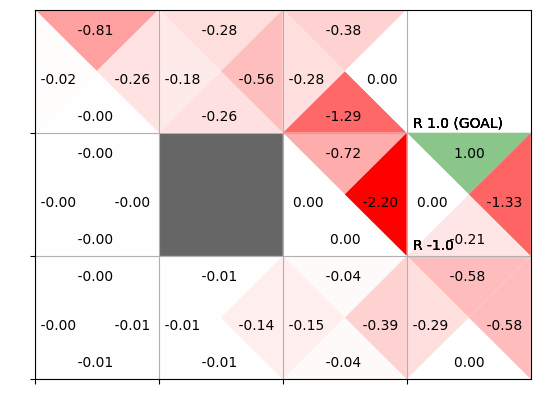

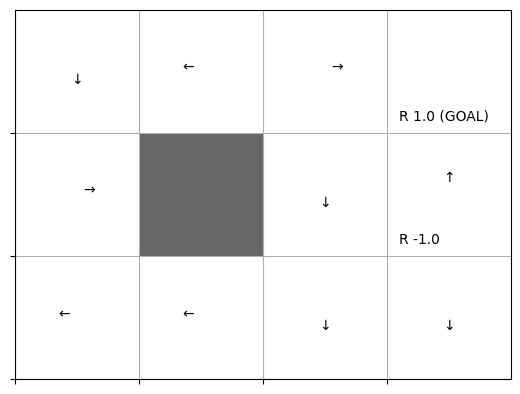

KeyboardInterrupt: 

In [70]:
env = GridWorld()
agent = McAgent()

episodes = 100
for episode in range(episodes):
    state = env.reset() # 처음 시작 상태로
    agent.reset() # 에이전트도 모두 초기화
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.add(state, action, reward)
        if done:
            agent.update()
            break
        
        state = next_state
    print(agent.pi)
    env.render_q(agent.Q)
    
env.render_q(agent.Q)

#### 5.4.3 입실론 그리디 정책으로 변경(첫 번째 개선)
- 코드를 보면 에이전트는 개선 단계에서 정책을 탐욕화함. 이때 행동은 단 하나로 고정됨.
- 예를 들어 아래 그림처럼 에이전트가 시작해서 목적지까지 간 경로가 있다고해보자.
- 만약 에이전트가 처음 시작에서 위로 가는 행동을 했다면 그쪽으로만 가는 경로로 1가지로 고정됨.
- 다른 데이터는 샘플이 수집이 안되는 문제 발생
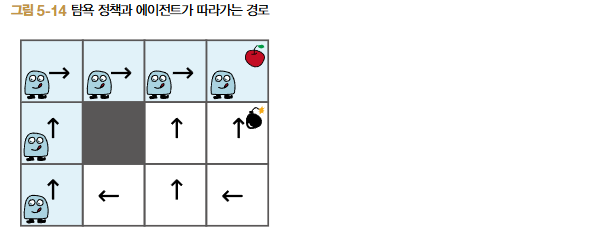

In [71]:
def greedy_probs(Q, state, epsilon=0, action_size =4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    
    base_prob = epsilon / action_size
    action_probs = {action : base_prob for action in range(action_size)}
    
    action_probs[max_action] += (1- epsilon) # 이 부분 개선
    return action_probs

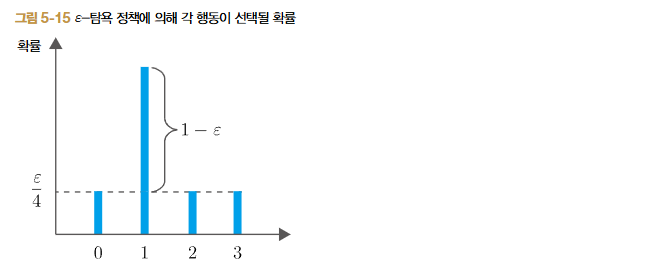

#### 5.4.4 고정값 $\alpha$ 방식으로 수행(두 번째 개선 사항)
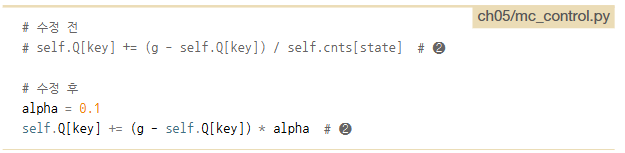
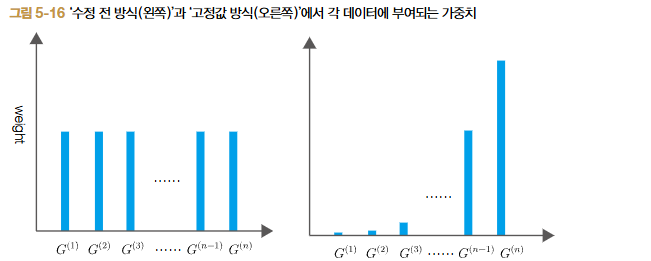

#### 5.4.5 몬테카를로법으로 정책 반복법 구현(개선 버전)

In [13]:
def greedy_probs(Q, state, epsilon=0, action_size =4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    
    base_prob = epsilon / action_size
    action_probs = {action : base_prob for action in range(action_size)}
    
    action_probs[max_action] += (1- epsilon)
    return action_probs

In [14]:
class McAgent :
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1 # 첫 번째 개선 : 입실론 탐욕 정책
        self.alpha = 0.1 # 두 번째 개선 Q 함수 갱신 시의 고정값 
        self.action_size = 4
        
        random_actions = {0 : 0.25, 1: 0.25, 2:0.25, 3: 0.25}
        self.pi = defaultdict(lambda : random_actions)
        self.Q = defaultdict(lambda : 0) # self.V = defaultdict  Q로 바뀜
        # self.cnts = defaultdict(lambda : 0) 이제 사용안함
        self.memeory = []
        
    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memeory.append(data)
        
    def reset(self) :
        self.memeory.clear()
        
    def update(self):
        G = 0
        for data in reversed(self.memeory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            #self.cnts[key] += 1
            self.Q[key] += (G - self.Q[key]) * self.alpha
            
            # state 의 정책 탐욕화
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)

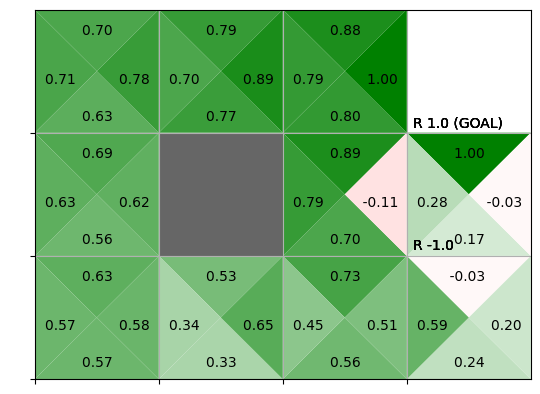

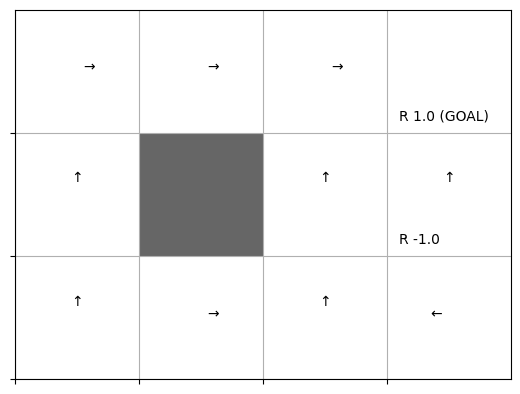

In [15]:
env = GridWorld()
agent = McAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset() # 처음 시작 상태로
    agent.reset() # 에이전트도 모두 초기화
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.add(state, action, reward)
        if done:
            agent.update()
            break
        
        state = next_state
env.render_q(agent.Q)

# 
### 5.5 오프 정책과 중요도 샘플링